## Overview plot

C:\Users\Henry\AppData\Local\Temp\ipykernel_2892\4256536572.py:26: RuntimeWarning: divide by zero encountered in divide
  & (nn_f["dist"] / nn_f["dist_error"] > 5)



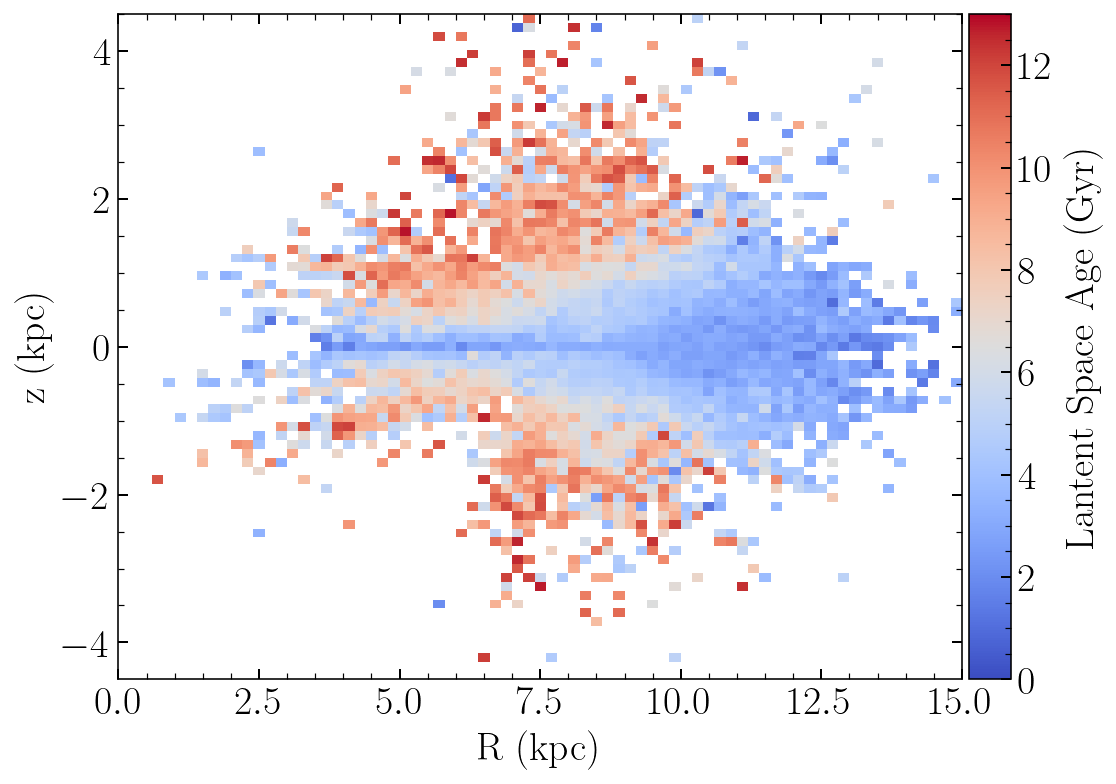

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from py.utils import orbits_params
from scipy.stats import binned_statistic_2d
from astroNN.shared import pylab_style
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.io import fits
from astroNN.apogee import allstar, apogee_astronn


pylab_style(paper=True)

_R0 = 8.23
_v0 = 249.44
_z0 = 0.0208

allstar_f = fits.getdata(allstar(dr=17))
nn_f = fits.getdata(apogee_astronn(dr=17))
age_f = pd.read_csv("./nn_latent_age_dr17.csv.gz")

good_idx = (~np.isnan(age_f["Age"])
            & (age_f["STARFLAG"]==0)
            & (age_f["ASPCAPFLAG"]==0)
            & (age_f["Age_Error"] / age_f["Age"] < 0.4)
            & (nn_f["dist"] / nn_f["dist_error"] > 5)
            & ~np.isnan(nn_f["galr"])
            & ~np.isnan(nn_f["galz"]))

allstar_f = allstar_f[good_idx]
nn_f = nn_f[good_idx]

vxvv = np.stack([nn_f["RA"], 
                 nn_f["DEC"], 
                 nn_f["weighted_dist"] / 1000, 
                 nn_f["pmra"], 
                 nn_f["pmdec"], 
                 allstar_f["VHELIO_AVG"]]).T
orbitparams = orbits_params(vxvv)
Lz = orbitparams["lz"]
galr = orbitparams["galr"]
galz = orbitparams["galz"]

stat, xe, ye, binnumber = binned_statistic_2d(galr, 
                                              galz, 
                                              age_f["Age"][good_idx], 
                                              range=((0, 15), (-4.5, 4.5)), 
                                              bins=(75, 75),
                                              statistic=np.nanmedian)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
mappable = ax.pcolormesh(xe, ye, stat.T, cmap="coolwarm", vmin=0, vmax=13, rasterized=True)
ax.set_xlim(0, 15)
ax.set_ylim(-4.5, 4.5)
ax.set_xlabel("R (kpc)")
ax.set_ylabel("z (kpc)")

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Lantent Space Age (Gyr)")
# fig.tight_layout()
fig.savefig("./figs/age_z_dist.pdf", bbox_inches="tight")

## Detailed Alpha everywhere plot

C:\Users\Henry\AppData\Local\Temp\ipykernel_2184\2026248298.py:26: RuntimeWarning: divide by zero encountered in divide
  & (nn_f["dist"] / nn_f["dist_error"] > 5)



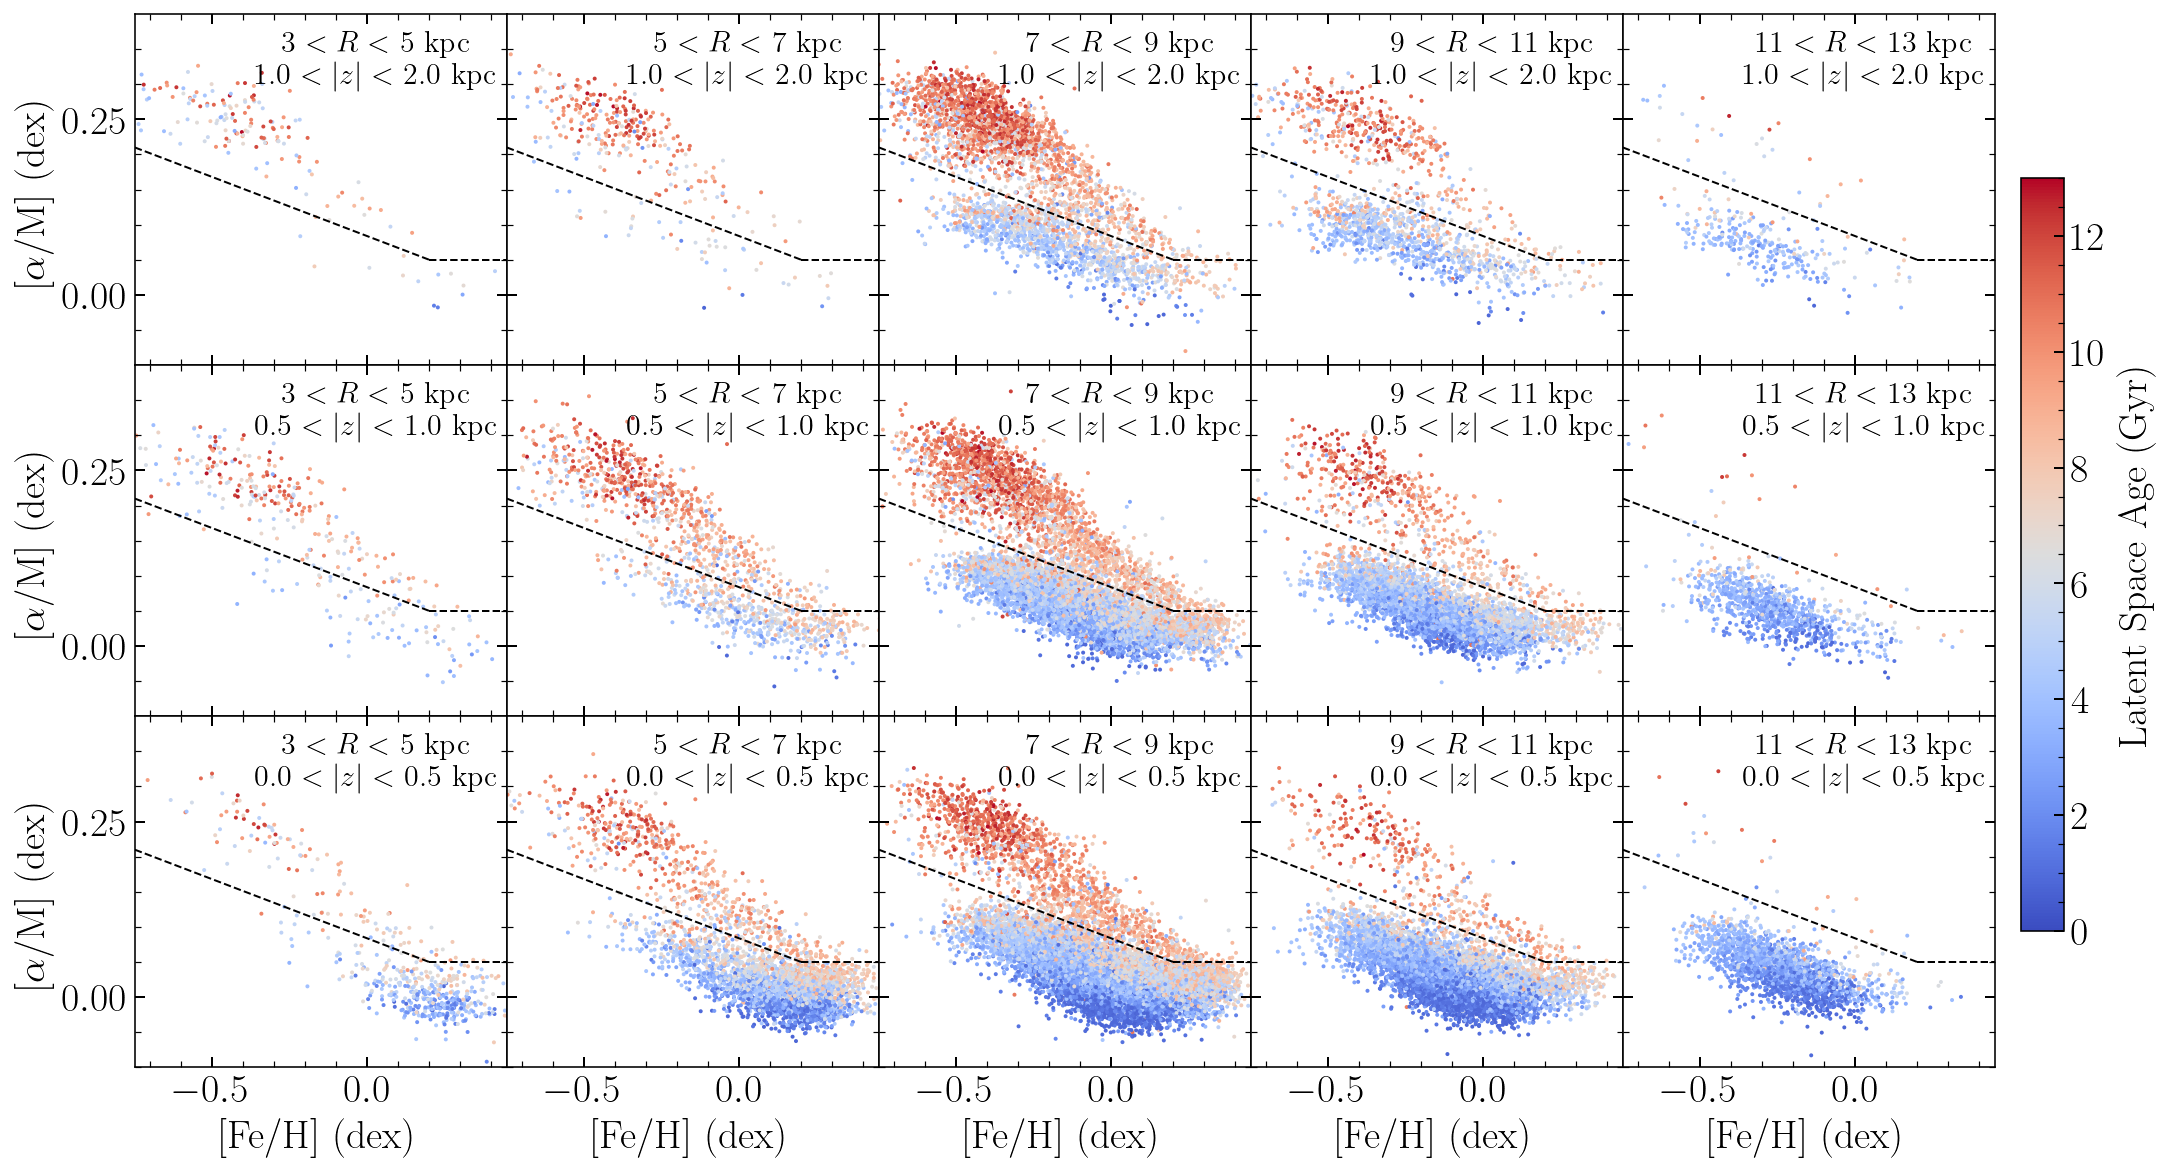

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from py.utils import orbits_params
from scipy.stats import binned_statistic_2d
from astropy.io import fits
from astroNN.shared import pylab_style
from astroNN.apogee import allstar, apogee_astronn
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

pylab_style(paper=True)


allstar_f = fits.getdata(allstar(dr=17))
nn_f = fits.getdata(apogee_astronn(dr=17))
age_f = pd.read_csv("./nn_latent_age_dr17.csv.gz")

good_idx = (
    ~np.isnan(age_f["Age"])
    & (age_f["STARFLAG"] == 0)
    & (age_f["ASPCAPFLAG"] == 0)
    & (age_f["Age_Error"] / age_f["Age"] < 0.5)
    & (nn_f["dist"] / nn_f["dist_error"] > 5)
    & ~np.isnan(nn_f["galr"])
    & ~np.isnan(nn_f["galz"])
)

allstar_f = allstar_f[good_idx]
nn_f = nn_f[good_idx]
age_f = age_f[good_idx]

vxvv = np.stack([nn_f["RA"], 
                 nn_f["DEC"], 
                 nn_f["weighted_dist"] / 1000, 
                 nn_f["pmra"], 
                 nn_f["pmdec"], 
                 allstar_f["VHELIO_AVG"]]).T
orbitparams = orbits_params(vxvv)
Lz = orbitparams["lz"]
galr = orbitparams["galr"]
galz = orbitparams["galz"]

xmajorLocator = MultipleLocator(0.5)
ymajorLocator = MultipleLocator(0.25)

# setup plots
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(20, 9.5))

height = 3
width = 5

inner1 = gridspec.GridSpecFromSubplotSpec(
    height, width+1, subplot_spec=gs[0], wspace=0, hspace=0
)
ax = [[plt.Subplot(fig, inner1[i, j]) for j in range(width+1)] for i in range(height)]

# 7 is Mg
aspcap_idx = 7

z = 2.

for i in range(height):
    R_gc_init = 3
    for j in range(width):
        good_idx = (
            (np.abs(galz) > (2-i)*0.5)
            & (np.abs(galz) < z)
            & (galr > R_gc_init + 2*j)
            & (galr < R_gc_init + (2*j + 2))
        )
        im = ax[i][j].scatter(
            x=allstar_f["FE_H"][good_idx],
            y=allstar_f["ALPHA_M"][good_idx],
            rasterized=True,
            s=1.0,
            c=age_f["Age"][good_idx],
            cmap="coolwarm", 
            vmin=0, 
            vmax=13
        )
        # eyeball to separate high and low alpha sequence
        ax[i][j].plot([-0.75, 0.2], [0.21, 0.05], ls="--", c="k")
        ax[i][j].plot([0.2, 0.45], [0.05, 0.05], ls="--", c="k")
        # ax[i][j].plot([-0.75, 0.0], [0.19, 0.04], ls="--", c="k")
        # ax[i][j].plot([0.0, 0.45], [0.04, 0.04], ls="--", c="k")
        ax[i][j].set_xlim(-0.75, 0.45)
        ax[i][j].set_ylim(-0.1, 0.4)
        ax[i][j].annotate(f"{R_gc_init + 2*j} $< R <$ {R_gc_init + (2*j + 2)} kpc\n {(2-i)*0.5} $< |z| <$ {z} kpc",
                          xy=(0.65, 0.80),
                          xycoords="axes fraction",
                          ha="center", 
                          fontsize=15
                          )

        if j != 0:
            ax[i][j].yaxis.set_major_formatter(NullFormatter())
            ax[i][j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i][0].yaxis.set_major_locator(ymajorLocator)
            ax[i][0].set_ylabel(f"[$\\alpha$/M] (dex)")

        if i == height - 1:
            if j == 0:
                ax[i][0].xaxis.set_major_locator(xmajorLocator)
        ax[i][j].set_xlabel("[Fe/H] (dex)")

        fig.add_subplot(ax[i][j])
    z -= (2-i)*0.5

# last "invisible" column
fig.add_subplot(ax[0][-1])
fig.add_subplot(ax[1][-1])
fig.add_subplot(ax[2][-1])
[i[-1].set_visible(False) for i in ax]

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=13)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.78, 0.21, 0.015, 0.55])
cbar = plt.colorbar(sm, orientation="vertical", cax=cbar_ax)
cbar.set_label("Latent Space Age (Gyr)")
fig.savefig("figs/alpha_age_Rz.pdf", bbox_inches="tight", dpi=77)


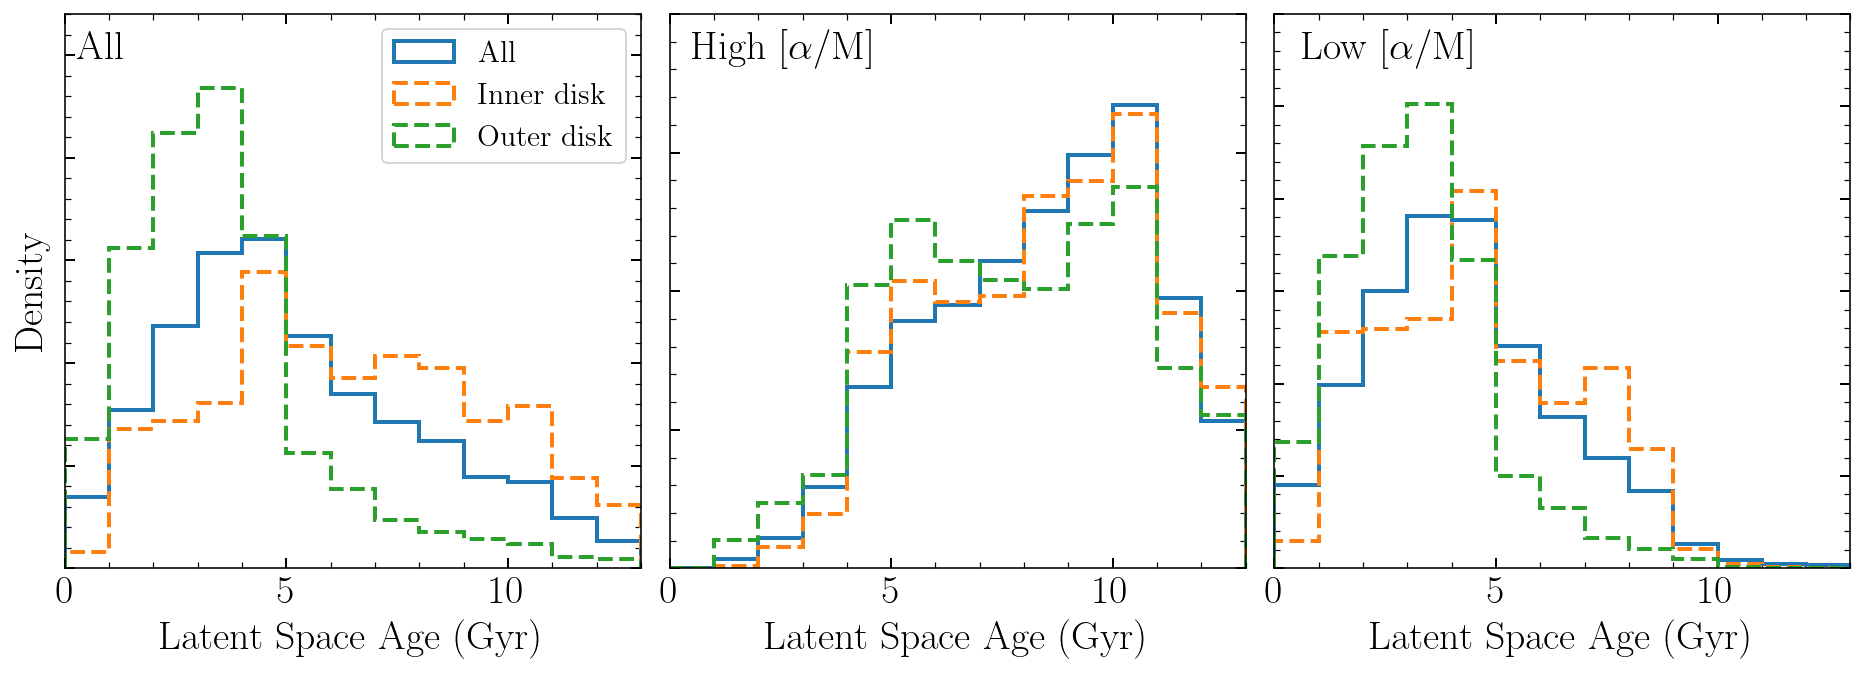

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={"wspace": 0.05})

good_idx = (
    ~np.isnan(age_f["Age"])
    & (age_f["STARFLAG"] == 0)
    & (age_f["ASPCAPFLAG"] == 0)
    & (age_f["Age_Error"] / age_f["Age"] < 0.4)
    & (nn_f["dist"] / nn_f["dist_error"] > 5)
    & ~np.isnan(nn_f["galr"])
    & ~np.isnan(nn_f["galz"])
    & (np.abs(nn_f["galz"]) < 2)
)
inner_disk = (good_idx & (3<galr) & (galr<6.))
outer_disk = (good_idx & (10<galr) & (galr<13))

ax1.hist(age_f["Age"], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax1.hist(age_f["Age"][inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax1.hist(age_f["Age"][outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax1.annotate("All",
             xy=(0.06, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)
ax1.legend()

high_alpha_idx = (good_idx & 
                    (allstar_f["ALPHA_M"] > (-0.221052631579*allstar_f["FE_H"]+0.0442105263158)) & 
                    (allstar_f["ALPHA_M"] > 0.05)
                    )

ax2.hist(age_f["Age"][high_alpha_idx], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax2.hist(age_f["Age"][high_alpha_idx & inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax2.hist(age_f["Age"][high_alpha_idx & outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax2.annotate("High [$\\alpha$/M]",
             xy=(0.20, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)

ax3.hist(age_f["Age"][~high_alpha_idx], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax3.hist(age_f["Age"][~high_alpha_idx & inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax3.hist(age_f["Age"][~high_alpha_idx & outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax3.annotate("Low [$\\alpha$/M]",
             xy=(0.20, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)

ax1.set_xlim(0, 13)
ax2.set_xlim(0, 13)
ax3.set_xlim(0, 13)
ax1.set_ylim(0, 0.27)
ax2.set_ylim(0, 0.20)
ax3.set_ylim(0, 0.30)

ax1.set_ylabel("Density")
ax1.set_xlabel("Latent Space Age (Gyr)")
ax2.set_xlabel("Latent Space Age (Gyr)")
ax3.set_xlabel("Latent Space Age (Gyr)")

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

fig.savefig("figs/age_alpha_hist.pdf", bbox_inches="tight")


[Text(0, 0.0, ''),
 Text(0, 0.1, ''),
 Text(0, 0.2, ''),
 Text(0, 0.30000000000000004, ''),
 Text(0, 0.4, '')]

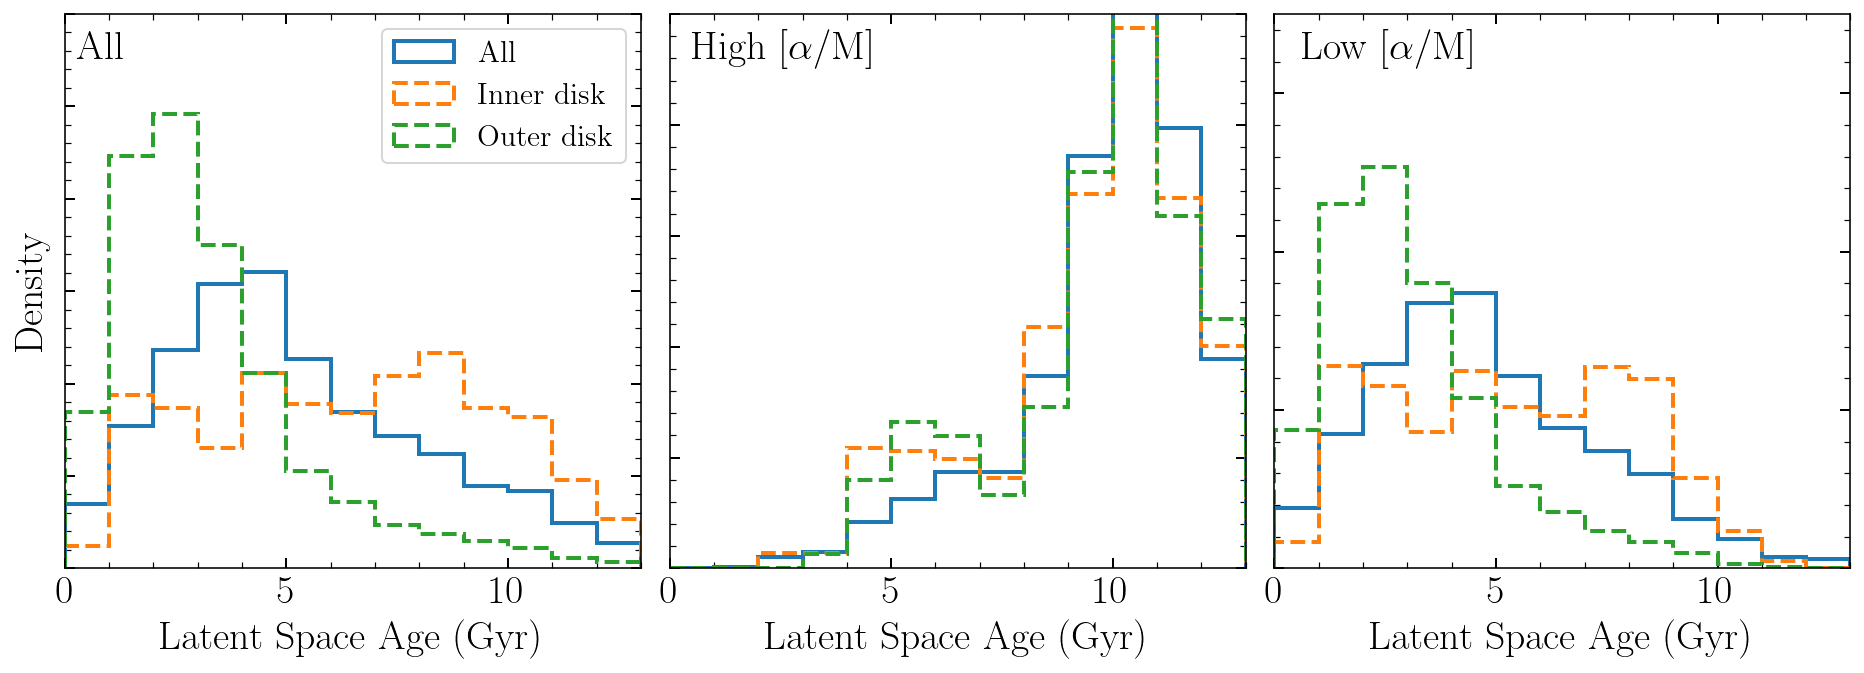

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={"wspace": 0.05})

good_idx = (
    ~np.isnan(age_f["Age"])
    & (age_f["STARFLAG"] == 0)
    & (age_f["ASPCAPFLAG"] == 0)
    & (age_f["Age_Error"] / age_f["Age"] < 0.4)
    & (nn_f["dist"] / nn_f["dist_error"] > 5)
    & ~np.isnan(nn_f["galr"])
    & ~np.isnan(nn_f["galz"])
    & (np.abs(nn_f["galz"]) < 2)
    & (allstar_f["logg"] > 2.55)
)
inner_disk = (good_idx & (3<nn_f["galr"]) & (nn_f["galr"]<6))
outer_disk = (good_idx & (10<nn_f["galr"]) & (nn_f["galr"]<13))

ax1.hist(age_f["Age"], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax1.hist(age_f["Age"][inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax1.hist(age_f["Age"][outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax1.annotate("All",
             xy=(0.06, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)
ax1.legend()

high_alpha_idx = (good_idx & 
                    (allstar_f["ALPHA_M"] > 0.18)
                    )

ax2.hist(age_f["Age"][high_alpha_idx], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax2.hist(age_f["Age"][high_alpha_idx & inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax2.hist(age_f["Age"][high_alpha_idx & outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax2.annotate("High [$\\alpha$/M]",
             xy=(0.20, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)

ax3.hist(age_f["Age"][~high_alpha_idx], range=(0, 13), bins=13, histtype="step", density=True, lw=2, label="All")
ax3.hist(age_f["Age"][~high_alpha_idx & inner_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Inner disk")
ax3.hist(age_f["Age"][~high_alpha_idx & outer_disk], range=(0, 13), bins=13, histtype="step", density=True, lw=2, ls="--", label="Outer disk")
ax3.annotate("Low [$\\alpha$/M]",
             xy=(0.20, 0.92),
             xycoords="axes fraction",
             ha="center", 
             fontsize=20)

ax1.set_xlim(0, 13)
ax2.set_xlim(0, 13)
ax3.set_xlim(0, 13)
ax1.set_ylim(0, 0.30)
ax2.set_ylim(0, 0.25)
ax3.set_ylim(0, 0.35)

ax1.set_ylabel("Density")
ax1.set_xlabel("Latent Space Age (Gyr)")
ax2.set_xlabel("Latent Space Age (Gyr)")
ax3.set_xlabel("Latent Space Age (Gyr)")

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

# fig.savefig("figs/age_alpha_hist.pdf", bbox_inches="tight")


In [4]:
# fraction of young high stars
np.sum(high_alpha_idx & (age_f["Age"] < 6)& (allstar_f["logg"] > 2.55)) / np.sum(high_alpha_idx& (allstar_f["logg"] > 2.55))

0.0651901379022148

C:\Users\Henry\AppData\Local\Temp\ipykernel_380\3111697277.py:25: RuntimeWarning: divide by zero encountered in divide
  & (nn_f["dist"] / nn_f["dist_error"] > 5)


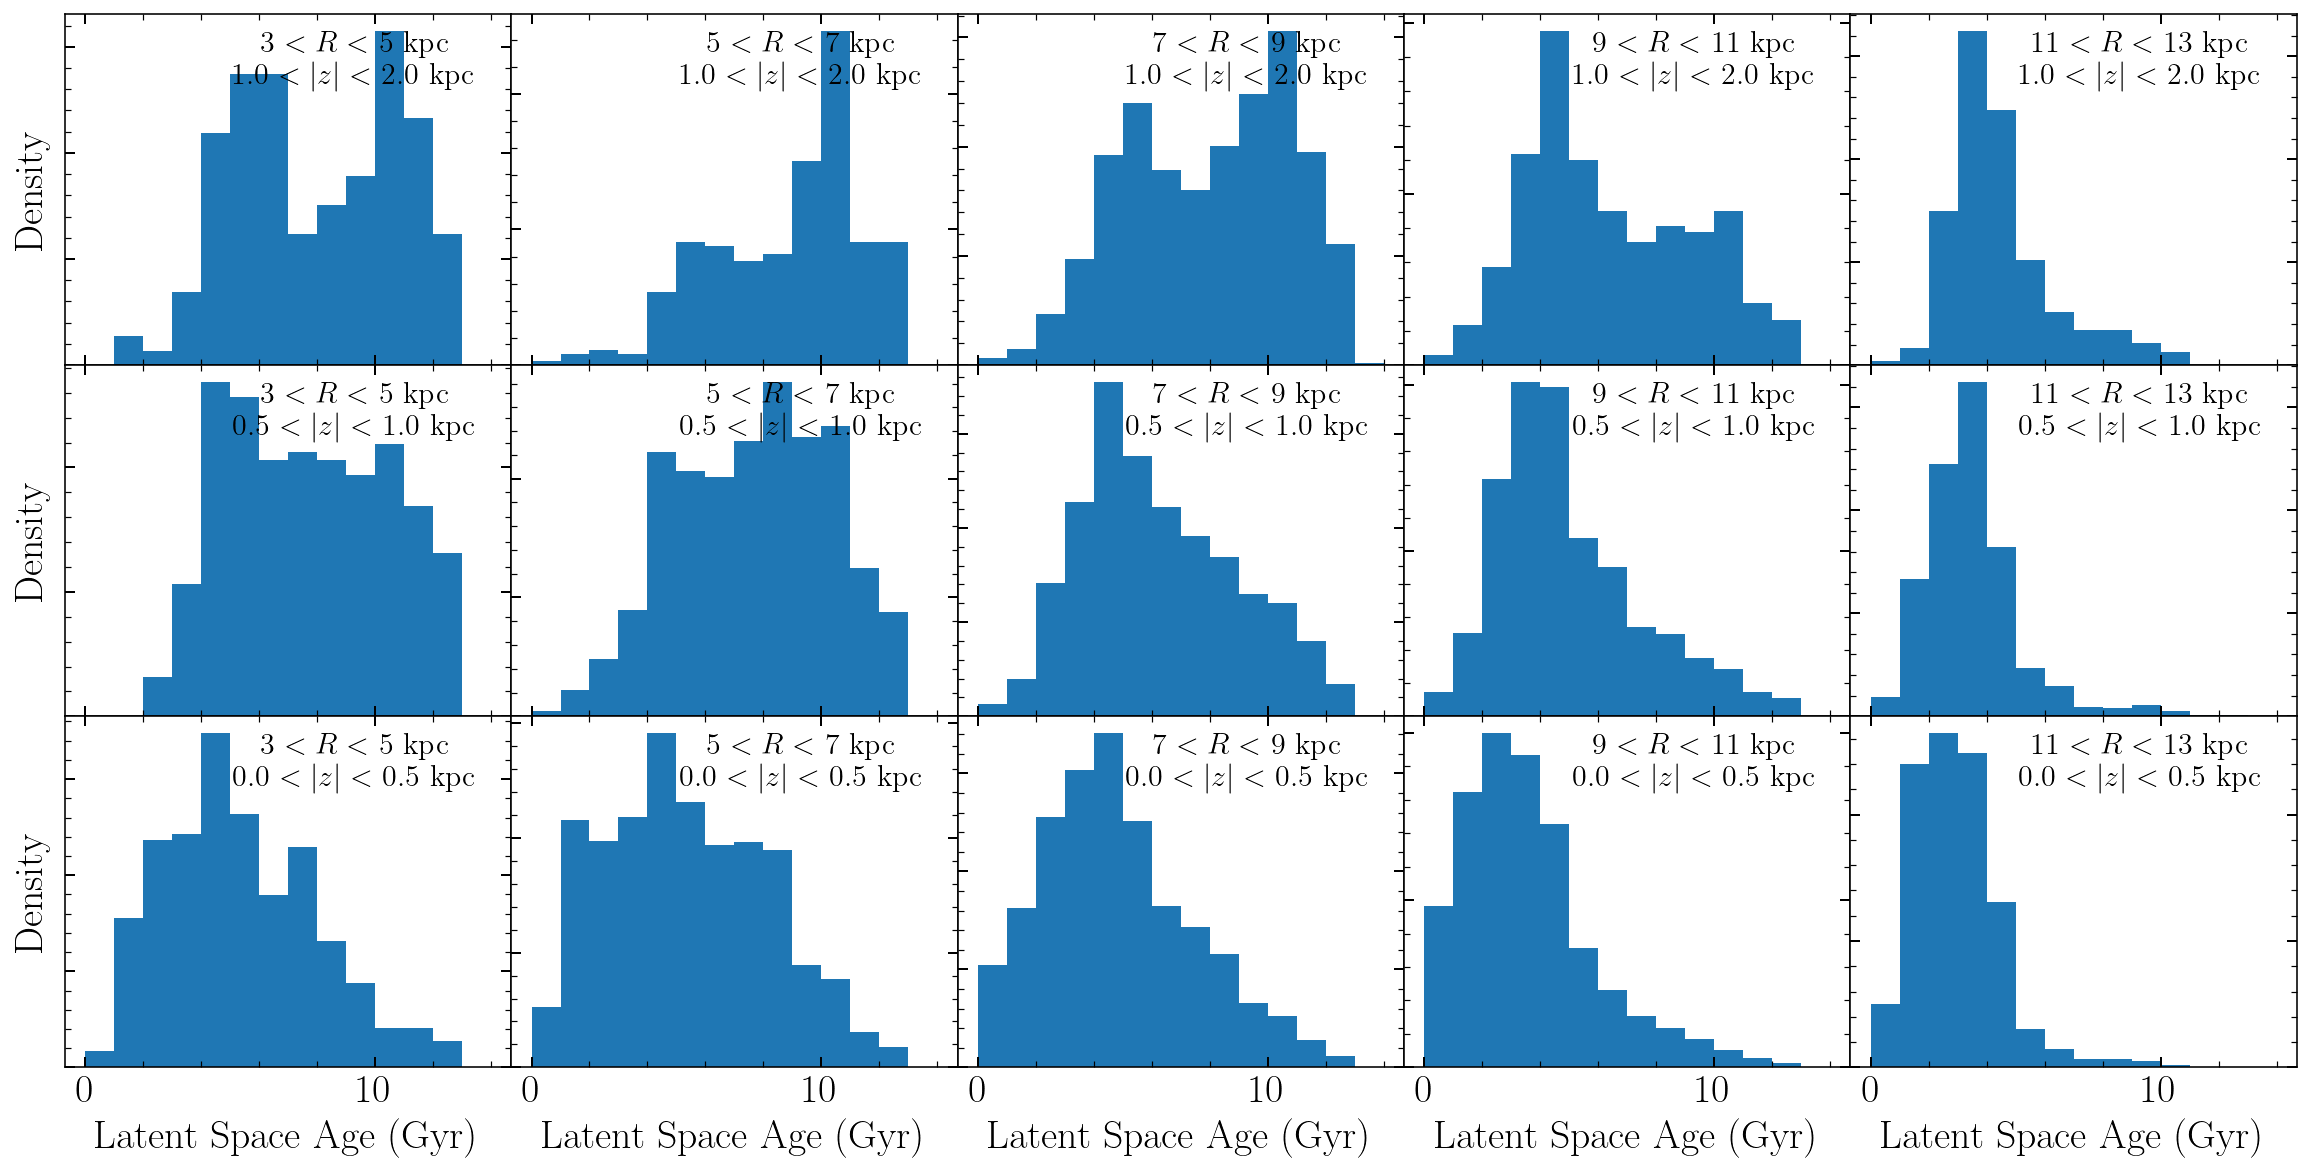

In [4]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.stats import binned_statistic_2d
from astropy.io import fits
from astroNN.shared import pylab_style
from astroNN.apogee import allstar, apogee_astronn
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

pylab_style(paper=True)


allstar_f = fits.getdata(allstar(dr=17))
nn_f = fits.getdata(apogee_astronn(dr=17))
age_f = pd.read_csv("./nn_latent_age_dr17.csv.gz")

good_idx = (
    ~np.isnan(age_f["Age"])
    & (age_f["STARFLAG"] == 0)
    & (age_f["ASPCAPFLAG"] == 0)
    & (age_f["Age_Error"] / age_f["Age"] < 0.4)
    & (nn_f["dist"] / nn_f["dist_error"] > 5)
    & ~np.isnan(nn_f["galr"])
    & ~np.isnan(nn_f["galz"])
)

allstar_f = allstar_f[good_idx]
nn_f = nn_f[good_idx]
age_f = age_f[good_idx]

# setup plots
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(20, 9.5))

height = 3
width = 5

inner1 = gridspec.GridSpecFromSubplotSpec(
    height, width, subplot_spec=gs[0], wspace=0, hspace=0
)
ax = [[plt.Subplot(fig, inner1[i, j]) for j in range(width)] for i in range(height)]

# 7 is Mg
aspcap_idx = 7

z = 2.

for i in range(height):
    R_gc_init = 3
    for j in range(width):
        good_idx = (
            (np.abs(nn_f["galz"]) > (2-i)*0.5)
            & (np.abs(nn_f["galz"]) < z)
            & (nn_f["galr"] > R_gc_init + 2*j)
            & (nn_f["galr"] < R_gc_init + (2*j + 2))
        )
        ax[i][j].hist(age_f["Age"][good_idx].to_numpy(), range=(0, 14), bins=14, density=True)
        # eyeball to separate high and low alpha sequence
        # ax[i][j].plot([-0.75, 0.2], [0.2, 0.02], ls="--", c="k")
        # ax[i][j].plot([0.2, 0.45], [0.02, 0.02], ls="--", c="k")
        # ax[i][j].set_xlim(-0.75, 0.45)
        # ax[i][j].set_ylim(-0.1, 0.4)
        high_alpha_idx = (good_idx & 
                          (allstar_f["ALPHA_M"] > (-0.18947368421052635*allstar_f["FE_H"]+0.05789473684210528)) & 
                          (allstar_f["ALPHA_M"] > 0.02)
                          )
        young_high_alpha_idx = (high_alpha_idx & (age_f["Age"].to_numpy() < 6))
        # {np.sum(young_high_alpha_idx) / np.sum(high_alpha_idx)}
        ax[i][j].annotate(f"{R_gc_init + 2*j} $< R <$ {R_gc_init + (2*j + 2)} kpc\n {(2-i)*0.5} $< |z| <$ {z} kpc",
                          xy=(0.65, 0.80),
                          xycoords="axes fraction",
                          ha="center", 
                          fontsize=15
                          )

        ax[i][j].yaxis.set_major_formatter(NullFormatter())
            
        if j != 0:
            pass
        else:
            ax[i][0].set_ylabel("Density")

        ax[i][j].set_xlabel("Latent Space Age (Gyr)")

        fig.add_subplot(ax[i][j])
    z -= (2-i)*0.5

# last "invisible" column
# fig.add_subplot(ax[0][-1])
# fig.add_subplot(ax[1][-1])
# fig.add_subplot(ax[2][-1])
# [i[-1].set_visible(False) for i in ax]

fig.savefig("figs/age_Rz_hist.pdf", bbox_inches="tight")
